In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(1)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetClean/train
# !mkdir ../datasetClean/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
def getDataBlock(presize=512,size=512):
    return DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_volumen,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [13]:
path = Path('../datasetClean/')
trainPath = path/'train'

In [14]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=32)

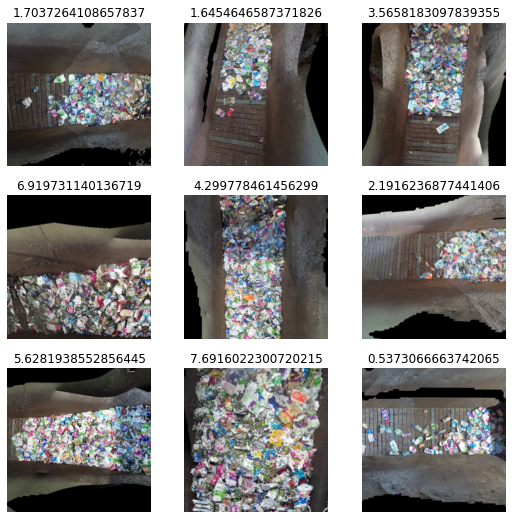

In [15]:
dls.show_batch()

In [16]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnet50Volumen')
]

In [17]:
from fastai.metrics import mae,rmse,mse

In [18]:
learn = cnn_learner(dls,resnet50,loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [19]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,51.424232,1284.832031,32.502239,35.844555,1284.832031,00:07


Better model found at epoch 0 with valid_loss value: 1284.83203125.


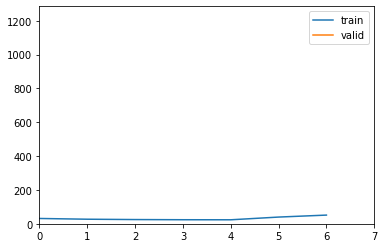

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,128.901321,219.185471,12.221791,14.804914,219.185471,00:06
1,70.112541,6.132024,1.726024,2.476292,6.132024,00:05
2,47.333057,13.078119,2.655475,3.616368,13.078119,00:05
3,35.395782,10.618085,3.047073,3.258540,10.618085,00:05
4,28.042868,8.049543,2.505110,2.837172,8.049543,00:06
5,22.682419,1.778155,1.151214,1.333475,1.778155,00:05
6,18.710424,4.199864,1.732593,2.049357,4.199864,00:05
7,15.723819,4.101392,1.527837,2.025189,4.101392,00:05
8,13.427091,0.598226,0.602968,0.773451,0.598226,00:05
9,11.631196,2.619550,1.364464,1.618502,2.619550,00:05


Better model found at epoch 0 with valid_loss value: 219.1854705810547.


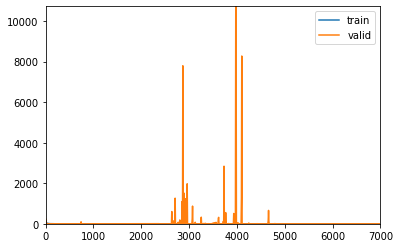

Better model found at epoch 1 with valid_loss value: 6.13202428817749.
Better model found at epoch 5 with valid_loss value: 1.7781553268432617.
Better model found at epoch 8 with valid_loss value: 0.5982264876365662.
Better model found at epoch 14 with valid_loss value: 0.5698420405387878.
Better model found at epoch 15 with valid_loss value: 0.45213013887405396.
Better model found at epoch 17 with valid_loss value: 0.34162601828575134.
Better model found at epoch 35 with valid_loss value: 0.33718881011009216.
Better model found at epoch 74 with valid_loss value: 0.3063470721244812.
Better model found at epoch 175 with valid_loss value: 0.27417370676994324.
Better model found at epoch 187 with valid_loss value: 0.2564496099948883.
Better model found at epoch 338 with valid_loss value: 0.24460594356060028.


In [20]:
learn.fine_tune(1000,base_lr=3e-2)

In [21]:
# learn.load('resnetrs50Masav2')

In [22]:
def is_test(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [23]:
dbtest = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_volumen,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=512,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [24]:
dlstest = dbtest.dataloaders(path,bs=16)

In [25]:
learn.dls=dlstest

In [26]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5162253379821777.


(#4) [0.8136163949966431,0.5162253379821777,0.9020068645477295,0.8136163949966431]

In [27]:
from sklearn.metrics import mean_absolute_error

In [28]:
preds,gt = learn.tta()

In [29]:
mean_absolute_error(gt,preds)

0.5172134